# Aprendiendo Fashion-MNIST con PyTorch

## Refs.

* https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

* https://github.com/zalandoresearch/fashion-mnist

* https://github.com/pranay414/Fashion-MNIST-Pytorch/blob/master/fashion_mnist.ipynb

## **Ejercicio 1)** Importando librerías

**0)** De ser necesario, **instale PyTorch** escribiendo

    !pip3 install torch torchvision torchaudio torchviz

**1)** Importe las librerías estandard de Python: `os`, `datetime`, `collections` y `pickle`.

**2)** Importe las siguientes librerías third party de Python: `matplotlib.pyplot`, `numpy`, `scipy`, `sklearn`, `pandas`, `dill` y `json`.

**3)** Importe las librerias necesarias de **PyTorch**: `torch` y `torchvision`.

**4)** Importe la librería: `google.colab`.

In [1]:
# 1.0)
!pip3 install torch torchvision torchaudio torchviz

/bin/bash: línea 1: /home/usuario/Documentos/RedesNeuronales/RN-FinalProyect/.venv/bin/pip3: no se puede ejecutar: no se ha encontrado el fichero requerido


In [2]:
# 1.1)
import os
import pickle
import datetime
from collections import defaultdict

In [3]:
# 1.2)
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
import pandas as pd
#import dill
import json

In [4]:
# 1.3)
import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
#from torchviz import make_dot

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## **Ejercicio 2)**

Bajando y Jugando con el dataset **Fashion-MNIST**.

**1)** Baje y transforme (i.e. normalize los valores de los pixeles) los conjuntos de entrenamiento y testeo de FashionMNIST.

**2)** Explore algunos ejemplos de estos conjuntos. Que formato poseen?

**3)** Visitando la página web de FashionMNIST, cree un diccionario de Python `Dict()` asociando cada categoría a un nombre adecuado de la misma.

**4)** Grafique un mosaico de 3x3 imagenes de FashionMNIST, cada una titulada con su respectiva clasificación

In [6]:
# 2.1)
# Define a transform to normalize the data
transform = transforms.Compose([
                                transforms.ToTensor()
                                ,transforms.Normalize((0.5,), (0.5,))
                                #,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

# Download and load the training data
train_set = datasets.FashionMNIST('MNIST_data/', download = True, train = True,  transform = transform)
valid_set = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

In [7]:
# 2.2)
len(train_set),len(valid_set)

(60000, 10000)

In [8]:
i = np.random.randint(len(train_set))
print(f"i={i}")
image,label = train_set[i]
label
image.shape

i=53483


torch.Size([1, 28, 28])

In [9]:
image.numpy().squeeze().shape

(28, 28)

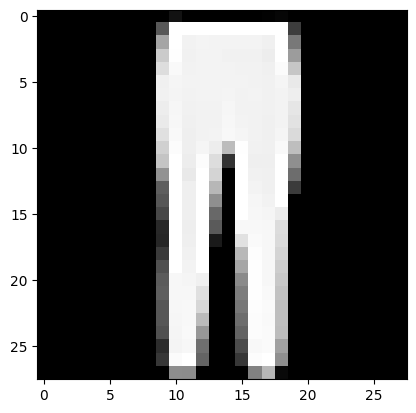

In [10]:
plt.imshow(image.numpy().squeeze(),cmap='Greys_r')

In [11]:
# 2.3)
label_names = {
    0: "T-shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

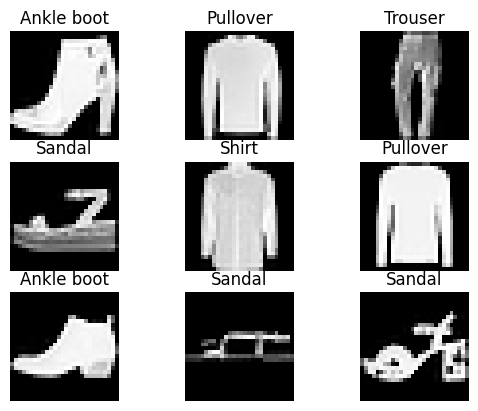

In [12]:
# 2.4)
figure = plt.figure()
cols, rows = 3,3
for i in range(1, cols*rows+1):
  j = torch.randint(len(train_set), size=(1,)).item()
  image, label = train_set[j]
  figure.add_subplot(rows, cols, i)
  plt.title(label_names[label])
  plt.axis("off")
  plt.imshow(image.numpy().squeeze(), cmap="Greys_r")
plt.show()

## Ejercicio 3)

Creando un `DataLoader` para alimentar el modelo con batchs (lotes) de entrenamiento.

**1)** Cree los `DataLoader`s para cada conjunto. Defínalos con un `batch_size` de 100 y con el flag `shuffle` seteado a `True`.

**2)** Use uno de los `DataLoader`s creados anteriormente para explorar algunos elementos del conjunto.

Notar que, el iterador devuelve el batch en un par `(image,label)`.

El objeto `images` es un tensor de dimensiones `(100,1,28,28)`.
El 100 es el tamaño del batch.
El 1 porque hay un solo canal (en este caso, un canal de escala de grises, pero podría haber varios, p. ej. uno por cada color de {Red, Green Blue} en caso que fuesen imagenes a color).
Luego, 28 y 28 porque cada imagen del dataset es de 28 x 28 píxeles.

El objeto `labels` es un tensor de dimensiones `(100,)`.
La $i$-ésima entrada `labels[i]` de `labels` es un número en $\{0,1,...,9\}$ indicando la categoría a la que pertenece la $i$-ésima imagen en el batch, guardada en `images[i]`.

In [13]:
# 3.1)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 100, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size = 100, shuffle = True)

In [14]:
# Cargar únicamente los pesos del Autoencoder preentrenado
import torch
from torch import nn
# Debes tener la misma definición de Autoencoder que se usó al entrenar
from autoencoder import Autoencoder  

checkpoint_path = "/home/usuario/Documentos/RedesNeuronales/RN-FinalProyect/Autoencoder/3_final/resultados/loss_results.pt"
checkpoint = torch.load(checkpoint_path, map_location="cpu")

dropout_autoencoder = 0.2
autoencoder = Autoencoder(dropout=dropout_autoencoder)
autoencoder.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

## Ejercicio 4)

Defina una red neuronal de 4 capas, una de entrada, dos ocultas de $n_1=128$ y $n_2=64$ neuronas, respectivamente, y una de salida de 10 neuronas.

En las capas intermedias utilice neuronas tipo ReLU y agregueles un *dropout* de p=0.2.
En la capa de salida no utilice funciones de activación ni dropout.

Las capas sucesivas tienen que estar totalmente conectadas entre si.

In [15]:
class Clasificadora1(nn.Module):
    def __init__(self, p, n1, n2, encoder=None):
        super().__init__()
        self._dropout = p

        self.encoder = encoder
        self.classifier = nn.Sequential(
            # Capa 0
            nn.Flatten(),
            
            # Capa 1
            nn.Linear(in_features = 64*7*7, out_features = n1),
            nn.ReLU(),
            nn.Dropout(p),
            
            # Capa 2
            nn.Linear(in_features = n1, out_features = n2),
            nn.ReLU(),
            nn.Dropout(p),

            # Capa 3
            nn.Linear(in_features = n2, out_features = 10)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x


class Clasificadora2(nn.Module):
    def __init__(self, p, n1, n2, n3, encoder=None):
        super().__init__()
        self._dropout = p

        self.encoder = encoder
        self.classifier = nn.Sequential(
            # Capa 0
            nn.Flatten(),
            
            # Capa 1
            nn.Linear(in_features = 64*7*7, out_features = n1),
            nn.ReLU(),
            nn.Dropout(p),
            
            # Capa 2
            nn.Linear(in_features = n1, out_features = n2),
            nn.ReLU(),
            nn.Dropout(p),
            
            # Capa 2
            nn.Linear(in_features = n2, out_features = n3),
            nn.ReLU(),
            nn.Dropout(p),

            # Capa 3
            nn.Linear(in_features = n3, out_features = 10)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

## Ejercicio 5)

Entrenamos el modelo

**1)** Implemente, en una función, un loop de entrenamiento que recorra los batchs (lotes).

**2)** Implemente, en una función, un loop de validación que recorra los batchs.

**3)** Inicialize dos `DataLoader`s llamados `train_loader` y `valid_loader` a partir del `train_set` (conjunto de entranmiento) y del `valid_set` (conjunto de validación) de Fashion-MNIST, respectivamente, y que usen batchs de 100 ejemplos.

**4)** Cree una función de pérdida usando la **Cross Entropy Loss**.

**IMPORTANTE:** Notar que la **Cross Entropy Loss** aplica automáticamente una `log_softmax`.

**5)** Cree un optimizador que utilice el método de **Stochastic Gradient Descent** con un learning rate igual a $10^{-3}$.

**6)** Cree una instancia del modelo.

**7)** Especifique en que dispositivo (`device`) va a trabajar: en una **CPU** o en una **GPU**.

**8)** Implemente un loop de entrenamiento y validación que trabaje con el `train_loader` y el `valid_loader`, respectivamente, usando un numero arbitrario de épocas.
Este loop debe guardar en cuatro listas los valores de los promedios del **Cross Entropy Loss** y las fracciones de clasificaciones correctas o **precisión** (accuracy) sobre el conjunto de **entrenamiento** y el de **validación**, respectivamente.

**IMPORTANTE:** No olvide copiar los batchs al dispositivo de trabajo.

**9)** Entrene y valide el modelo.

**10)** Use las listas del inciso anterior para graficar en función de las épocas la **Cross Entropy Loss** de **entrenamiento** y de **validación**.
Realize un gráfico análogo pero con la **precisión**.
Discuta y comente, cual es el número óptimo de épocas de entrenamiento?

**11)** Repita los experimentos variando hiperparámetros. Por ejemplo:

- El learning-rate.
- El optimizador (ej. puede usar ADAM).
- El valor de dropout.
- El número de neuronas en las capas intermedias.
- El número de épocas de entrenamiento.
- El tamaño de los lotes.

Discuta los resultados.

In [16]:
# 5.1)
# Definimos la función de entrenamiento
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    num_samples = len(dataloader.dataset)
    nun_batches = len(dataloader)
    sum_loss = 0
    sum_correct = 0
    sum_samples = 0

    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        batch_size = len(X)
        sum_samples += batch_size
        pred = model(X)
        loss = loss_fn(pred,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sum_loss += loss.item()*batch_size
        sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        if batch % (nun_batches/10) == 0:
            avrg_loss = sum_loss/sum_samples
            precision = sum_correct/sum_samples
            print(f"@train_loop batch={batch:>5d} avrg_loss={avrg_loss:>7f} processed samples={100*sum_samples/num_samples:>5.1f}%")
    assert num_samples == sum_samples
    avrg_loss = sum_loss/sum_samples
    precision = sum_correct/sum_samples
    return avrg_loss, precision

In [17]:
# 5.2)
# Definimos la función de validación
def eval_loop(dataloader, model, loss_fn):
    model.eval()
    num_samples = len(dataloader.dataset)
    nun_batches = len(dataloader)
    sum_loss = 0
    sum_correct = 0
    sum_samples = 0

    with torch.no_grad():
        for X,y in dataloader:
          X = X.to(device)
          y = y.to(device)
          batch_size = len(X)
          sum_samples += batch_size
          pred = model(X)
          loss = loss_fn(pred,y)
          sum_loss += loss.item()*batch_size
          sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    assert num_samples == sum_samples
    avrg_loss = sum_loss/sum_samples
    precision = sum_correct/sum_samples
    print(f"@eval_loop avg_loss={avrg_loss:>8f} precision={100*precision:>0.1f}%")
    return avrg_loss, precision

In [18]:
# 5.3)
batch_size = 100
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)

num_train_batches = len(train_loader)
num_valid_batches = len(valid_loader)
print(f'num_train_batches={num_train_batches}')
print(f'num_valid_batches={num_valid_batches}')

num_train_batches=600
num_valid_batches=100


In [19]:
# 5.4)
loss_fn = nn.CrossEntropyLoss()

In [20]:
# 5.5)
# Ejemplo: pasar encoder a tu modelo Clasificadora con dropout fijo en la clasificadora
# p_dropout_clf = 0.2
# clasificador = Clasificadora(p=p_dropout_clf, n1=128, n2=64, encoder=autoencoder.encoder)

In [21]:
# 5.6)
#learning_rate = 1e-3
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(clasificador.classifier.parameters(), lr=learning_rate, eps=1e-08, weight_decay= 0, amsgrad= False)

In [22]:
# 5.7)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#clasificador = clasificador.to(device)

In [ ]:
"""
# -------------------------
# Configuración común
# -------------------------

p_dropout_clf = 0.2
learning_rate = 1e-3
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_fn = torch.nn.CrossEntropyLoss()  # Ejemplo, usar el que tengas
results_base_path = "results"

# Crear carpeta base si no existe
os.makedirs(results_base_path, exist_ok=True)

# -------------------------
# BLOQUE 1: Clasificadora 2 capas
# -------------------------
experimentos_2capas = {
    "Exp1": {"n1": 64,  "n2": 32},
    "Exp2": {"n1": 128, "n2": 64},
    "Exp3": {"n1": 512, "n2": 256}
}

results_2capas = {}
path_2capas = os.path.join(results_base_path, "2capas")
os.makedirs(path_2capas, exist_ok=True)

for nombre_exp, params in experimentos_2capas.items():
    print(f"\n============================")
    print(f"      EJECUTANDO 2CAPAS {nombre_exp}")
    print(f"============================")

    clf = Clasificadora1(
        p=p_dropout_clf,
        n1=params["n1"],
        n2=params["n2"],
        encoder=autoencoder.encoder
    ).to(device)

    optimizer = torch.optim.Adam(clf.classifier.parameters(), lr=learning_rate)

    # Inicializar listas de métricas
    list_avg_train_loss_incorrecta = []
    list_avg_train_loss = []
    list_avg_valid_loss = []
    list_train_precision_incorrecta = []
    list_train_precision = []
    list_valid_precision = []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        # TRAIN LOOP con métricas incorrectas
        train_avg_loss_incorrecta, train_precision_incorrecta = train_loop(train_loader, clf, loss_fn, optimizer)
        # TRAIN LOOP normal (solo para monitoreo)
        train_avg_loss, train_precision = eval_loop(train_loader, clf, loss_fn)
        # VALID LOOP
        valid_avg_loss, valid_precision = eval_loop(valid_loader, clf, loss_fn)

        # Guardar métricas
        list_avg_train_loss_incorrecta.append(train_avg_loss_incorrecta)
        list_avg_train_loss.append(train_avg_loss)
        list_avg_valid_loss.append(valid_avg_loss)
        list_train_precision_incorrecta.append(train_precision_incorrecta)
        list_train_precision.append(train_precision)
        list_valid_precision.append(valid_precision)

    # --------------------
    # Guardar resultados por experimento (métricas + config)
    # --------------------
    results_2capas[nombre_exp] = {
        "config": {
            "tipo_modelo": "Clasificadora1",
            "p_dropout_clf": p_dropout_clf,
            "learning_rate": learning_rate,
            "num_epochs": num_epochs,
            "n1": params["n1"],
            "n2": params["n2"]
        },
        "train_loss_incorrecta": list_avg_train_loss_incorrecta,
        "train_loss": list_avg_train_loss,
        "valid_loss": list_avg_valid_loss,
        "train_precision_incorrecta": list_train_precision_incorrecta,
        "train_precision": list_train_precision,
        "valid_precision": list_valid_precision
    }

    # Guardar métricas en archivo .pkl
    with open(os.path.join(path_2capas, f"{nombre_exp}_results.pkl"), "wb") as f:
        pickle.dump(results_2capas[nombre_exp], f)

    # Guardar pesos del modelo y estado del optimizador en .pt
    torch.save(
        {
            "config": results_2capas[nombre_exp]["config"],
            "model_state_dict": clf.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        },
        os.path.join(path_2capas, f"{nombre_exp}_model.pt"),
    )

    # Guardar resumen corto en JSON con últimos valores
    resumen = {
        "config": results_2capas[nombre_exp]["config"],
        "final_train_loss": list_avg_train_loss[-1],
        "final_valid_loss": list_avg_valid_loss[-1],
        "final_train_precision": list_train_precision[-1],
        "final_valid_precision": list_valid_precision[-1],
    }
    with open(os.path.join(path_2capas, f"{nombre_exp}_summary.json"), "w") as fjson:
        json.dump(resumen, fjson, indent=4)

print("✅ BLOQUE 2 CAPAS FINALIZADO")
"""

'\n# -------------------------\n# Configuración común\n# -------------------------\n\np_dropout_clf = 0.2\nlearning_rate = 1e-3\nnum_epochs = 100\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\nloss_fn = torch.nn.CrossEntropyLoss()  # Ejemplo, usar el que tengas\nresults_base_path = "results"\n\n# Crear carpeta base si no existe\nos.makedirs(results_base_path, exist_ok=True)\n\n# -------------------------\n# BLOQUE 1: Clasificadora 2 capas\n# -------------------------\nexperimentos_2capas = {\n    "Exp1": {"n1": 64,  "n2": 32},\n    "Exp2": {"n1": 128, "n2": 64},\n    "Exp3": {"n1": 512, "n2": 256}\n}\n\nresults_2capas = {}\npath_2capas = os.path.join(results_base_path, "2capas")\nos.makedirs(path_2capas, exist_ok=True)\n\nfor nombre_exp, params in experimentos_2capas.items():\n    print(f"\n============================")\n    print(f"      EJECUTANDO 2CAPAS {nombre_exp}")\n    print(f"============================")\n\n    clf = Clasificadora1(\n        p=p_drop

In [24]:
# -------------------------
# Configuración común
# -------------------------
p_dropout_clf = 0.2
learning_rate = 1e-3
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_fn = torch.nn.CrossEntropyLoss()  # Ejemplo, usar el que tengas
results_base_path = "results"

# Crear carpeta base si no existe
os.makedirs(results_base_path, exist_ok=True)

# -------------------------
# BLOQUE 2: Clasificadora 3 capas
# -------------------------
experimentos_3capas = {
    "Exp1": {"n1": 128, "n2": 64,  "n3": 32},
    "Exp2": {"n1": 256, "n2": 128, "n3": 64},
    "Exp3": {"n1": 512, "n2": 256, "n3": 128}
}

results_3capas = {}
path_3capas = os.path.join(results_base_path, "3capas")
os.makedirs(path_3capas, exist_ok=True)

for nombre_exp, params in experimentos_3capas.items():
    print(f"\n============================")
    print(f"      EJECUTANDO 3CAPAS {nombre_exp}")
    print(f"============================")

    clf = Clasificadora2(
        p=p_dropout_clf,
        n1=params["n1"],
        n2=params["n2"],
        n3=params["n3"],
        encoder=autoencoder.encoder
    ).to(device)

    optimizer = torch.optim.Adam(clf.classifier.parameters(), lr=learning_rate)

    # Inicializar listas de métricas
    list_avg_train_loss_incorrecta = []
    list_avg_train_loss = []
    list_avg_valid_loss = []
    list_train_precision_incorrecta = []
    list_train_precision = []
    list_valid_precision = []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        # TRAIN LOOP con métricas incorrectas
        train_avg_loss_incorrecta, train_precision_incorrecta = train_loop(train_loader, clf, loss_fn, optimizer)
        # TRAIN LOOP normal (solo monitoreo)
        train_avg_loss, train_precision = eval_loop(train_loader, clf, loss_fn)
        # VALID LOOP
        valid_avg_loss, valid_precision = eval_loop(valid_loader, clf, loss_fn)

        # Guardar métricas
        list_avg_train_loss_incorrecta.append(train_avg_loss_incorrecta)
        list_avg_train_loss.append(train_avg_loss)
        list_avg_valid_loss.append(valid_avg_loss)
        list_train_precision_incorrecta.append(train_precision_incorrecta)
        list_train_precision.append(train_precision)
        list_valid_precision.append(valid_precision)

    # --------------------
    # Guardar resultados por experimento (métricas + config)
    # --------------------
    results_3capas[nombre_exp] = {
        "config": {
            "tipo_modelo": "Clasificadora2",
            "p_dropout_clf": p_dropout_clf,
            "learning_rate": learning_rate,
            "num_epochs": num_epochs,
            "n1": params["n1"],
            "n2": params["n2"],
            "n3": params["n3"],
        },
        "train_loss_incorrecta": list_avg_train_loss_incorrecta,
        "train_loss": list_avg_train_loss,
        "valid_loss": list_avg_valid_loss,
        "train_precision_incorrecta": list_train_precision_incorrecta,
        "train_precision": list_train_precision,
        "valid_precision": list_valid_precision,
    }

    # Guardar métricas en archivo .pkl
    with open(os.path.join(path_3capas, f"{nombre_exp}_results.pkl"), "wb") as f:
        pickle.dump(results_3capas[nombre_exp], f)

    # Guardar pesos del modelo y estado del optimizador en .pt
    torch.save(
        {
            "config": results_3capas[nombre_exp]["config"],
            "model_state_dict": clf.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        },
        os.path.join(path_3capas, f"{nombre_exp}_model.pt"),
    )

    # Guardar resumen corto en JSON con últimos valores
    resumen = {
        "config": results_3capas[nombre_exp]["config"],
        "final_train_loss": list_avg_train_loss[-1],
        "final_valid_loss": list_avg_valid_loss[-1],
        "final_train_precision": list_train_precision[-1],
        "final_valid_precision": list_valid_precision[-1],
    }
    with open(os.path.join(path_3capas, f"{nombre_exp}_summary.json"), "w") as fjson:
        json.dump(resumen, fjson, indent=4)

print("✅ BLOQUE 3 CAPAS FINALIZADO")


      EJECUTANDO 3CAPAS Exp1

Epoch 1/100
@train_loop batch=    0 avrg_loss=2.297680 processed samples=  0.2%
@train_loop batch=   60 avrg_loss=1.424953 processed samples= 10.2%
@train_loop batch=  120 avrg_loss=1.140660 processed samples= 20.2%
@train_loop batch=  180 avrg_loss=0.995406 processed samples= 30.2%
@train_loop batch=  240 avrg_loss=0.921899 processed samples= 40.2%
@train_loop batch=  300 avrg_loss=0.867079 processed samples= 50.2%
@train_loop batch=  360 avrg_loss=0.828191 processed samples= 60.2%
@train_loop batch=  420 avrg_loss=0.792972 processed samples= 70.2%
@train_loop batch=  480 avrg_loss=0.770879 processed samples= 80.2%
@train_loop batch=  540 avrg_loss=0.747977 processed samples= 90.2%
@eval_loop avg_loss=0.449151 precision=83.4%
@eval_loop avg_loss=0.470756 precision=82.5%

Epoch 2/100
@train_loop batch=    0 avrg_loss=0.516776 processed samples=  0.2%
@train_loop batch=   60 avrg_loss=0.532880 processed samples= 10.2%
@train_loop batch=  120 avrg_loss=0.52

In [25]:
"""
# -------------------------
# RESULTADOS FINALES
# -------------------------
print("\n============================")
print("   RESULTADOS FINALES BLOQUE 2 CAPAS")
print("============================")

final_results_2capas = {}

for exp in results_2capas:
    train_loss_final = results_2capas[exp]["train_loss"][-1]
    valid_loss_final = results_2capas[exp]["valid_loss"][-1]
    train_prec_final = results_2capas[exp]["train_precision"][-1]
    valid_prec_final = results_2capas[exp]["valid_precision"][-1]

    final_results_2capas[exp] = valid_prec_final

    print(f"\n--- {exp} ---")
    print(f"Train Loss final:       {train_loss_final:.4f}")
    print(f"Valid Loss final:       {valid_loss_final:.4f}")
    print(f"Train Precision final:  {train_prec_final:.4f}")
    print(f"Valid Precision final:  {valid_prec_final:.4f}")

# Elegir mejor experimento 2 capas
best_exp_2capas = max(final_results_2capas, key=final_results_2capas.get)
best_precision_2capas = final_results_2capas[best_exp_2capas]

print("\n============================")
print("   MEJOR EXPERIMENTO BLOQUE 2 CAPAS")
print("============================")
print(f"Ganador: {best_exp_2capas}")
print(f"Mejor Valid Precision: {best_precision_2capas:.4f}")
"""


'\n# -------------------------\n# RESULTADOS FINALES\n# -------------------------\nprint("\n============================")\nprint("   RESULTADOS FINALES BLOQUE 2 CAPAS")\nprint("============================")\n\nfinal_results_2capas = {}\n\nfor exp in results_2capas:\n    train_loss_final = results_2capas[exp]["train_loss"][-1]\n    valid_loss_final = results_2capas[exp]["valid_loss"][-1]\n    train_prec_final = results_2capas[exp]["train_precision"][-1]\n    valid_prec_final = results_2capas[exp]["valid_precision"][-1]\n\n    final_results_2capas[exp] = valid_prec_final\n\n    print(f"\n--- {exp} ---")\n    print(f"Train Loss final:       {train_loss_final:.4f}")\n    print(f"Valid Loss final:       {valid_loss_final:.4f}")\n    print(f"Train Precision final:  {train_prec_final:.4f}")\n    print(f"Valid Precision final:  {valid_prec_final:.4f}")\n\n# Elegir mejor experimento 2 capas\nbest_exp_2capas = max(final_results_2capas, key=final_results_2capas.get)\nbest_precision_2capas = fin

In [26]:
# -------------------------
# RESULTADOS FINALES BLOQUE 3 CAPAS
# -------------------------
print("\n============================")
print("   RESULTADOS FINALES BLOQUE 3 CAPAS")
print("============================")

final_results_3capas = {}

for exp in results_3capas:
    train_loss_final = results_3capas[exp]["train_loss"][-1]
    valid_loss_final = results_3capas[exp]["valid_loss"][-1]
    train_prec_final = results_3capas[exp]["train_precision"][-1]
    valid_prec_final = results_3capas[exp]["valid_precision"][-1]

    final_results_3capas[exp] = valid_prec_final

    print(f"\n--- {exp} ---")
    print(f"Train Loss final:       {train_loss_final:.4f}")
    print(f"Valid Loss final:       {valid_loss_final:.4f}")
    print(f"Train Precision final:  {train_prec_final:.4f}")
    print(f"Valid Precision final:  {valid_prec_final:.4f}")

# Elegir mejor experimento 3 capas
best_exp_3capas = max(final_results_3capas, key=final_results_3capas.get)
best_precision_3capas = final_results_3capas[best_exp_3capas]

print("\n============================")
print("   MEJOR EXPERIMENTO BLOQUE 3 CAPAS")
print("============================")
print(f"Ganador: {best_exp_3capas}")
print(f"Mejor Valid Precision: {best_precision_3capas:.4f}")



   RESULTADOS FINALES BLOQUE 3 CAPAS

--- Exp1 ---
Train Loss final:       0.1798
Valid Loss final:       0.3258
Train Precision final:  0.9318
Valid Precision final:  0.8896

--- Exp2 ---
Train Loss final:       0.1425
Valid Loss final:       0.3155
Train Precision final:  0.9458
Valid Precision final:  0.8966

--- Exp3 ---
Train Loss final:       0.1428
Valid Loss final:       0.3088
Train Precision final:  0.9460
Valid Precision final:  0.8993

   MEJOR EXPERIMENTO BLOQUE 3 CAPAS
Ganador: Exp3
Mejor Valid Precision: 0.8993


In [27]:
"""
import matplotlib.pyplot as plt

# ----------------------------
#       GRÁFICO BLOQUE 2 CAPAS
# ----------------------------
exp_labels_2capas = {
    "Exp1": "Exp 1 (64-32)",
    "Exp2": "Exp 2 (128-64)",
    "Exp3": "Exp 3 (512-256)"
}

epoch = list(range(1, num_epochs + 1))

plt.figure(figsize=(8,5))
for exp in results_2capas:
    plt.plot(epoch, results_2capas[exp]["valid_loss"],
             label=f'{exp_labels_2capas[exp]} Valid loss', linestyle="-")
    plt.plot(epoch, results_2capas[exp]["train_loss"],
             label=f'{exp_labels_2capas[exp]} Train loss', linestyle=":")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Autoencoder + Clasificadora (2 capas)")
plt.legend()
plt.tight_layout()
plt.savefig("results/2capas/experimentos_loss_2capas.png")
plt.show()
"""

'\nimport matplotlib.pyplot as plt\n\n# ----------------------------\n#       GRÁFICO BLOQUE 2 CAPAS\n# ----------------------------\nexp_labels_2capas = {\n    "Exp1": "Exp 1 (64-32)",\n    "Exp2": "Exp 2 (128-64)",\n    "Exp3": "Exp 3 (512-256)"\n}\n\nepoch = list(range(1, num_epochs + 1))\n\nplt.figure(figsize=(8,5))\nfor exp in results_2capas:\n    plt.plot(epoch, results_2capas[exp]["valid_loss"],\n             label=f\'{exp_labels_2capas[exp]} Valid loss\', linestyle="-")\n    plt.plot(epoch, results_2capas[exp]["train_loss"],\n             label=f\'{exp_labels_2capas[exp]} Train loss\', linestyle=":")\n\nplt.xlabel("Epoch")\nplt.ylabel("Loss")\nplt.title("Autoencoder + Clasificadora (2 capas)")\nplt.legend()\nplt.tight_layout()\nplt.savefig("results/2capas/experimentos_loss_2capas.png")\nplt.show()\n'

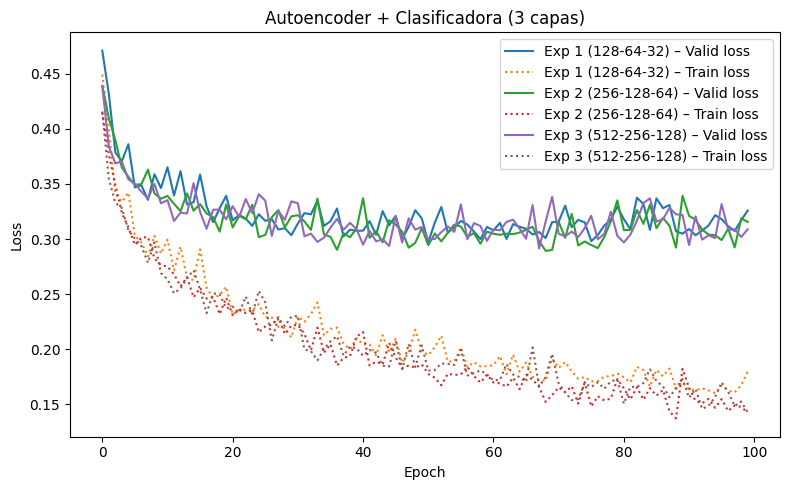

In [32]:
# ----------------------------
#       GRÁFICO BLOQUE 3 CAPAS
# ----------------------------

exp_labels_3capas = {
    "Exp1": "Exp 1 (128-64-32)",
    "Exp2": "Exp 2 (256-128-64)",
    "Exp3": "Exp 3 (512-256-128)"
}

plt.figure(figsize=(8,5))

for exp in results_3capas:
    epochs = range(len(results_3capas[exp]["valid_loss"]))  # eje x correcto

    plt.plot(epochs, results_3capas[exp]["valid_loss"],
             label=f'{exp_labels_3capas[exp]} – Valid loss',
             linestyle="-")

    plt.plot(epochs, results_3capas[exp]["train_loss"],
             label=f'{exp_labels_3capas[exp]} – Train loss',
             linestyle=":")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Autoencoder + Clasificadora (3 capas)")
plt.legend()
plt.tight_layout()
plt.savefig("results/3capas/experimentos_loss_3capas.png")
plt.show()


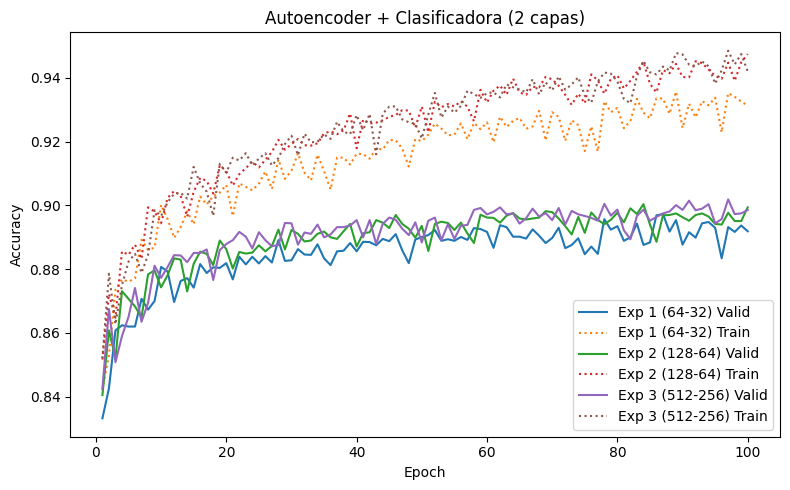

In [ ]:
"""
import matplotlib.pyplot as plt

# ----------------------------
#       GRÁFICO ACCURACY BLOQUE 2 CAPAS
# ----------------------------
plt.figure(figsize=(8,5))
for exp in results_2capas:
    plt.plot(epoch, results_2capas[exp]["valid_precision"],
             label=f'{exp_labels_2capas[exp]} Valid', linestyle="-")
    plt.plot(epoch, results_2capas[exp]["train_precision"],
             label=f'{exp_labels_2capas[exp]} Train', linestyle=":")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Autoencoder + Clasificadora (2 capas)")
plt.legend()
plt.tight_layout()
plt.savefig("results/2capas/experimentos_accuracy_2capas.png")
plt.show()
"""


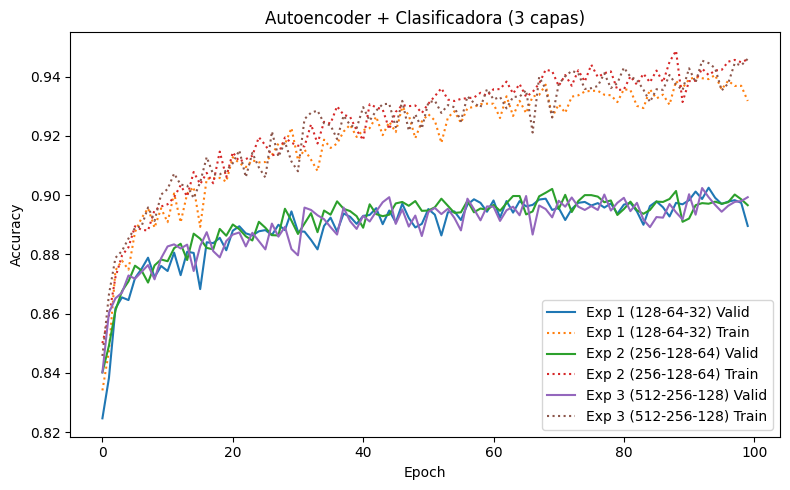

In [33]:
# ----------------------------
#       GRÁFICO ACCURACY BLOQUE 3 CAPAS
# ----------------------------
plt.figure(figsize=(8,5))

for exp in results_3capas:
    epochs = range(len(results_3capas[exp]["valid_precision"]))  # eje x correcto

    plt.plot(epochs, results_3capas[exp]["valid_precision"],
             label=f'{exp_labels_3capas[exp]} Valid',
             linestyle="-")

    plt.plot(epochs, results_3capas[exp]["train_precision"],
             label=f'{exp_labels_3capas[exp]} Train',
             linestyle=":")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Autoencoder + Clasificadora (3 capas)")
plt.legend()
plt.tight_layout()
plt.savefig("results/3capas/experimentos_accuracy_3capas.png")
plt.show()


Mejor EXP 2 capas: Exp3  PROM: 0.8692 cutoff: 13
Mejor EXP 3 capas: Exp2  PROM: 0.86649 cutoff: 10


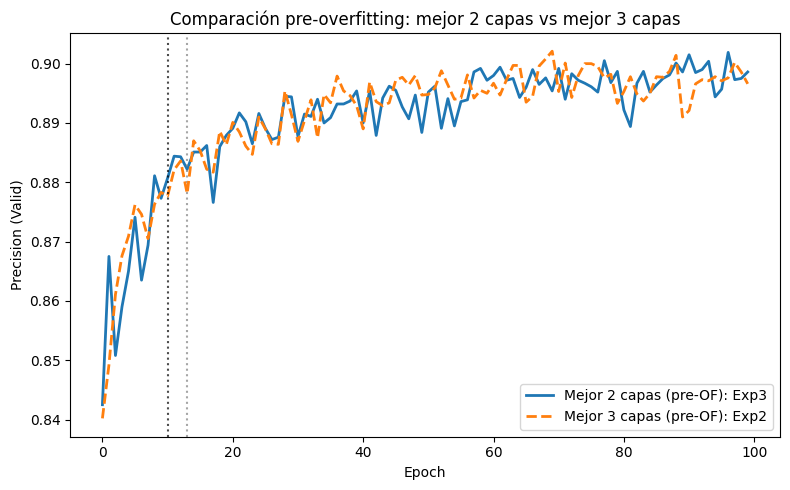

In [38]:
import pickle
import os
import matplotlib.pyplot as plt

# -------------------------------------------
# Función para detectar inicio de overfitting
# -------------------------------------------
def detectar_overfitting(train_loss, valid_loss):
    for i in range(1, len(valid_loss)):
        if valid_loss[i] > valid_loss[i-1] and train_loss[i] <= train_loss[i-1]:
            return i  # epoch donde empieza el sobreajuste
    return len(valid_loss)  # no hubo overfitting


# -------------------------------------------
# Cargar métricas de 2 capas
# -------------------------------------------
results_2capas = {}
path_2 = "results/2capas/"

for fname in os.listdir(path_2):
    if fname.endswith("_results.pkl"):
        exp_name = fname.replace("_results.pkl", "")
        with open(os.path.join(path_2, fname), "rb") as f:
            results_2capas[exp_name] = pickle.load(f)

# -------------------------------------------
# Cargar métricas de 3 capas
# -------------------------------------------
results_3capas = {}
path_3 = "results/3capas/"

for fname in os.listdir(path_3):
    if fname.endswith("_results.pkl"):
        exp_name = fname.replace("_results.pkl", "")
        with open(os.path.join(path_3, fname), "rb") as f:
            results_3capas[exp_name] = pickle.load(f)


# -------------------------------------------
# Elegir el mejor experimento de cada grupo
# -------------------------------------------
def mejor_experimento(results_dict):
    mejores = {}
    for exp, data in results_dict.items():
        train_loss = data["train_loss"]
        valid_loss = data["valid_loss"]
        valid_prec = data["valid_precision"]

        # 1. detectar overfitting
        cutoff = detectar_overfitting(train_loss, valid_loss)

        # 2. precisión promedio pre-overfitting
        prec_promedio = sum(valid_prec[:cutoff]) / cutoff

        mejores[exp] = (prec_promedio, cutoff)

    # elegir el mejor
    best_exp = max(mejores, key=lambda k: mejores[k][0])
    return best_exp, mejores[best_exp]


best_exp_2, info2 = mejor_experimento(results_2capas)
best_exp_3, info3 = mejor_experimento(results_3capas)

print("Mejor EXP 2 capas:", best_exp_2, " PROM:", info2[0], "cutoff:", info2[1])
print("Mejor EXP 3 capas:", best_exp_3, " PROM:", info3[0], "cutoff:", info3[1])


# -------------------------------------------
# Graficar las mejores curvas
# -------------------------------------------
epochs_2 = range(len(results_2capas[best_exp_2]["valid_precision"]))
epochs_3 = range(len(results_3capas[best_exp_3]["valid_precision"]))

plt.figure(figsize=(8,5))

plt.plot(
    epochs_2,
    results_2capas[best_exp_2]["valid_precision"],
    label=f"Mejor 2 capas (pre-OF): {best_exp_2}",
    linewidth=2
)

plt.axvline(info2[1], color='gray', linestyle=':', alpha=0.7)  # cutoff 2 capas

plt.plot(
    epochs_3,
    results_3capas[best_exp_3]["valid_precision"],
    label=f"Mejor 3 capas (pre-OF): {best_exp_3}",
    linestyle="--",
    linewidth=2
)

plt.axvline(info3[1], color='black', linestyle=':', alpha=0.7)  # cutoff 3 capas

plt.xlabel("Epoch")
plt.ylabel("Precision (Valid)")
plt.title("Comparación pre-overfitting: mejor 2 capas vs mejor 3 capas")
plt.legend()
plt.tight_layout()
plt.savefig("results/comparacion_precision_pre_overfitting.png")
plt.show()


In [39]:
import pickle
import os
import numpy as np

# -------------------------
# CONFIG
# -------------------------
β = 0.005  # penalización por pico

# -------------------------
# FUNCIONES AUXILIARES
# -------------------------

def detectar_overfitting(train_loss, valid_loss):
    for i in range(1, len(valid_loss)):
        if valid_loss[i] > valid_loss[i-1] and train_loss[i] <= train_loss[i-1]:
            return i
    return len(valid_loss)

def contar_picos(curva):
    picos = 0
    for i in range(2, len(curva)):
        if curva[i-1] > curva[i] and curva[i-1] > curva[i-2]:
            picos += 1
    return picos

def evaluar_caso(data):
    train_loss = data["train_loss"]
    valid_loss = data["valid_loss"]
    valid_precision = data["valid_precision"]

    # detectar early OF
    cutoff = detectar_overfitting(train_loss, valid_loss)

    # precisión media antes del OF
    prom = np.mean(valid_precision[:cutoff])

    # contar picos
    picos = contar_picos(valid_precision[:cutoff])

    # score estabilidad
    score = prom - β * picos

    return {
        "prom": prom,
        "picos": picos,
        "cutoff": cutoff,
        "score": score
    }

# -------------------------
# CARGA DE EXPERIMENTOS EXP2 Y EXP3
# -------------------------

def cargar_experimentos(path, exp_prefix):
    resultados = []
    for fname in os.listdir(path):
        if fname.startswith(exp_prefix) and fname.endswith("_results.pkl"):
            with open(os.path.join(path, fname), "rb") as f:
                data = pickle.load(f)
            resultados.append((fname, data))
    return resultados

exp2_cases = cargar_experimentos("results/2capas", "Exp2")
exp3_cases = cargar_experimentos("results/3capas", "Exp3")

# -------------------------
# EVALUAR CADA CASO
# -------------------------
def evaluar_experimento(cases):
    evaluaciones = []
    for fname, data in cases:
        info = evaluar_caso(data)
        evaluaciones.append((fname, info))
    # elegir el mejor caso para el experimento
    best_case = max(evaluaciones, key=lambda x: x[1]["score"])
    return best_case, evaluaciones

best_exp2, evals2 = evaluar_experimento(exp2_cases)
best_exp3, evals3 = evaluar_experimento(exp3_cases)

print("\n===== RESULTADOS EXP2 =====")
for fname, info in evals2:
    print(fname, info)

print("\n→ Mejor caso EXP2:", best_exp2[0], best_exp2[1])

print("\n===== RESULTADOS EXP3 =====")
for fname, info in evals3:
    print(fname, info)

print("\n→ Mejor caso EXP3:", best_exp3[0], best_exp3[1])

# -------------------------
# COMPARAR EXP2 VS EXP3
# -------------------------
print("\n===================================")
print(" COMPARACIÓN FINAL EXP2 vs EXP3")
print("===================================")

if best_exp2[1]["score"] > best_exp3[1]["score"]:
    print("⭐ EXP2 gana por estabilidad y precisión pre-overfitting")
else:
    print("⭐ EXP3 gana por estabilidad y precisión pre-overfitting")



===== RESULTADOS EXP2 =====
Exp2_results.pkl {'prom': np.float64(0.8686833333333333), 'picos': 3, 'cutoff': 12, 'score': np.float64(0.8536833333333332)}

→ Mejor caso EXP2: Exp2_results.pkl {'prom': np.float64(0.8686833333333333), 'picos': 3, 'cutoff': 12, 'score': np.float64(0.8536833333333332)}

===== RESULTADOS EXP3 =====
Exp3_results.pkl {'prom': np.float64(0.8552333333333332), 'picos': 0, 'cutoff': 3, 'score': np.float64(0.8552333333333332)}

→ Mejor caso EXP3: Exp3_results.pkl {'prom': np.float64(0.8552333333333332), 'picos': 0, 'cutoff': 3, 'score': np.float64(0.8552333333333332)}

 COMPARACIÓN FINAL EXP2 vs EXP3
⭐ EXP3 gana por estabilidad y precisión pre-overfitting


Mejores casos de 2 capas: {'Exp1': ('Exp1', {'config': {'tipo_modelo': 'Clasificadora1', 'p_dropout_clf': 0.2, 'learning_rate': 0.001, 'num_epochs': 100, 'n1': 64, 'n2': 32}, 'train_loss_incorrecta': [0.7115345541636149, 0.5174666024247805, 0.4694451592862606, 0.44483381589253745, 0.42791634442905585, 0.4139702763656775, 0.40231588470439117, 0.394267555475235, 0.39329233425358934, 0.3843129734446605, 0.37860548553367457, 0.374660935079058, 0.3732438999166091, 0.3619288185238838, 0.35838219890991846, 0.36067885845899583, 0.35799279804031053, 0.3539311383912961, 0.3459680336217085, 0.3468427076439063, 0.35194511361420155, 0.33735112418731056, 0.33356120067338146, 0.3357972424228986, 0.33281741457680863, 0.3333763950069745, 0.3288267455001672, 0.3268252337475618, 0.32555897122869887, 0.32235951617360115, 0.3235788319508235, 0.3230595110853513, 0.31691596301893393, 0.32044353579481444, 0.3154081756124894, 0.31189664265761774, 0.32048262491822244, 0.317179091150562, 0.315253276526928, 0.313

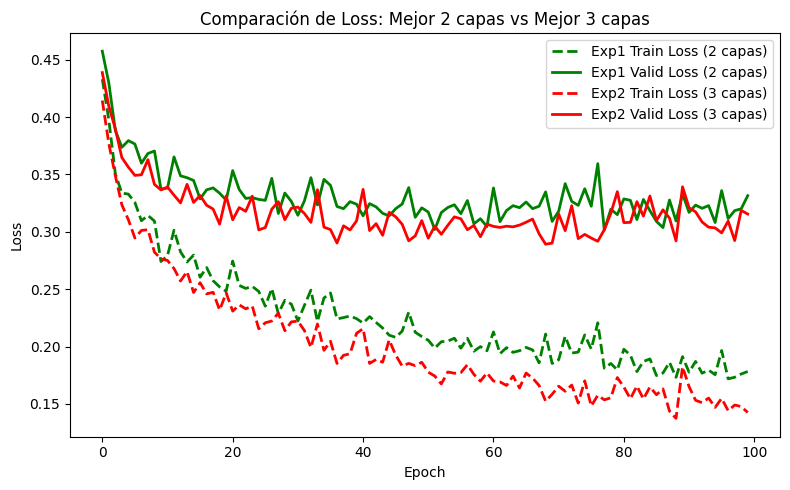

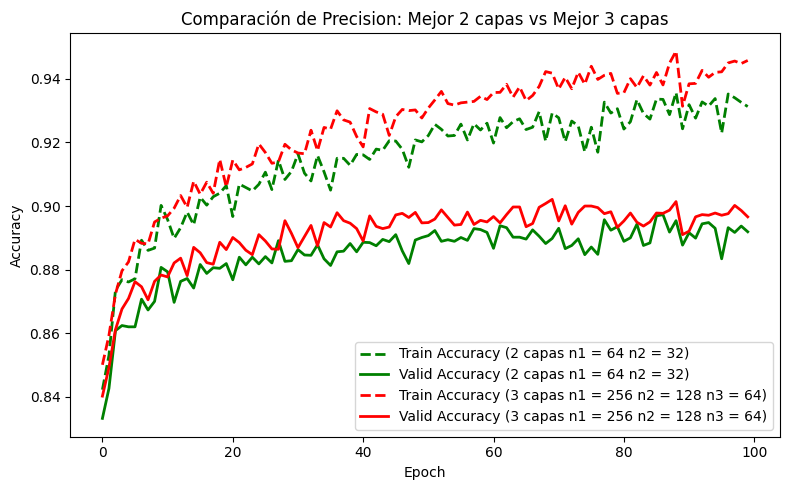

In [47]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt


# ----------------------------------------------------------
# Funciones auxiliares
# ----------------------------------------------------------
def detectar_overfitting(train_loss, valid_loss):
    """
    Devuelve el epoch donde comienza el overfitting.
    Si no hay, devuelve el total de epochs.
    """
    for i in range(1, len(valid_loss)):
        if valid_loss[i] > valid_loss[i-1] and train_loss[i] <= train_loss[i-1]:
            return i
    return len(valid_loss)


def estabilidad(curva):
    """Menos picos = más estabilidad."""
    picos = 0
    for i in range(2, len(curva)):
        if curva[i-1] > curva[i] and curva[i-1] > curva[i-2]:
            picos += 1
    return picos


def score_modelo(data, beta=0.01):
    """
    Score = promedio precision pre-overfitting – penalización por picos.
    """
    train_loss = data["train_loss"]
    valid_loss = data["valid_loss"]
    valid_prec = data["valid_precision"]

    cutoff = detectar_overfitting(train_loss, valid_loss)
    prec_prom = np.mean(valid_prec[:cutoff])
    picos = estabilidad(valid_prec[:cutoff])

    score = prec_prom - beta * picos

    return score, cutoff


def cargar_experimentos(path):
    dic = {}
    for fname in os.listdir(path):
        if fname.endswith("_results.pkl"):
            exp = fname.replace("_results.pkl", "")
            with open(os.path.join(path, fname), "rb") as f:
                dic[exp] = pickle.load(f)
    return dic


# ----------------------------------------------------------
# Cargar resultados
# ----------------------------------------------------------
results_2 = cargar_experimentos("results/2capas")
results_3 = cargar_experimentos("results/3capas")


# ----------------------------------------------------------
# Agrupar casos por experimento (Exp1, Exp2, Exp3)
# ----------------------------------------------------------
def agrupar_por_exp(results):
    grupos = {"Exp1": [], "Exp2": [], "Exp3": []}
    for name, logs in results.items():
        base = name.split("_")[0]   # Exp1, Exp2, Exp3
        grupos[base].append((name, logs))
    return grupos


grupo_2 = agrupar_por_exp(results_2)
grupo_3 = agrupar_por_exp(results_3)


# ----------------------------------------------------------
# Elegir mejor caso dentro de cada experimento
# ----------------------------------------------------------
def mejor_caso(grupos):
    mejores = {}
    for exp, casos in grupos.items():
        mejor = max(
            casos,
            key=lambda x: score_modelo(x[1])[0]
        )
        mejores[exp] = mejor
    return mejores


mejores_2 = mejor_caso(grupo_2)
mejores_3 = mejor_caso(grupo_3)

print("Mejores casos de 2 capas:", mejores_2)
print("Mejores casos de 3 capas:", mejores_3)


# ----------------------------------------------------------
# Elegir mejor experimento general (el mejor entre Exp1/2/3)
# ----------------------------------------------------------
mejor_exp_2 = max(mejores_2.items(), key=lambda x: score_modelo(x[1][1])[0])
mejor_exp_3 = max(mejores_3.items(), key=lambda x: score_modelo(x[1][1])[0])

nombre_2, data_2 = mejor_exp_2[1]
nombre_3, data_3 = mejor_exp_3[1]

print("\nGANADOR 2 CAPAS:", nombre_2)
print("GANADOR 3 CAPAS:", nombre_3)


# ----------------------------------------------------------
# Graficar LOSS del mejor de 2 vs mejor de 3
# ----------------------------------------------------------
plt.figure(figsize=(8, 5))

plt.plot(data_2["train_loss"], label=f"{nombre_2} Train Loss (2 capas)", linewidth=2, linestyle="--", color="green")
plt.plot(data_2["valid_loss"], label=f"{nombre_2} Valid Loss (2 capas)", linewidth=2, color="green")

plt.plot(data_3["train_loss"], label=f"{nombre_3} Train Loss (3 capas)", linewidth=2, linestyle="--", color="red")
plt.plot(data_3["valid_loss"], label=f"{nombre_3} Valid Loss (3 capas)", linewidth=2, color="red")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Comparación de Loss: Mejor 2 capas vs Mejor 3 capas")
plt.legend()
plt.tight_layout()
plt.savefig("results/comparacion_loss_best2_vs_best3.png")
plt.show()


# ----------------------------------------------------------
# Graficar PRECISION del mejor de 2 vs mejor de 3
# ----------------------------------------------------------
plt.figure(figsize=(8, 5))

plt.plot(data_2["train_precision"], label=f"Train Accuracy (2 capas n1 = 64 n2 = 32)", linewidth=2, linestyle="--", color="green")
plt.plot(data_2["valid_precision"], label=f"Valid Accuracy (2 capas n1 = 64 n2 = 32)", linewidth=2, color="green")

plt.plot(data_3["train_precision"], label=f"Train Accuracy (3 capas n1 = 256 n2 = 128 n3 = 64)", linewidth=2, linestyle="--", color="red")
plt.plot(data_3["valid_precision"], label=f"Valid Accuracy (3 capas n1 = 256 n2 = 128 n3 = 64)", linewidth=2, color="red")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Comparación de Precision: Mejor 2 capas vs Mejor 3 capas")
plt.legend()
plt.tight_layout()
plt.savefig("results/comparacion_precision_best2_vs_best3.png")
plt.show()



MEJORES 2 CAPAS
Mejor promedio: ('Exp3', {'promedio': np.float64(0.890749), 'suavidad': np.float64(0.36029999999999995), 'max_precision': np.float64(0.9019), 'curva': array([0.8425, 0.8675, 0.8508, 0.859 , 0.865 , 0.8741, 0.8635, 0.8694,
       0.8811, 0.8773, 0.8807, 0.8844, 0.8843, 0.8822, 0.8851, 0.8851,
       0.8862, 0.8766, 0.886 , 0.8879, 0.8891, 0.8917, 0.8902, 0.8865,
       0.8916, 0.8891, 0.8872, 0.8876, 0.8945, 0.8944, 0.8877, 0.8915,
       0.8911, 0.894 , 0.89  , 0.8909, 0.8932, 0.8932, 0.8937, 0.8954,
       0.89  , 0.8954, 0.8879, 0.8942, 0.8962, 0.8955, 0.8927, 0.8907,
       0.8947, 0.8884, 0.8952, 0.8962, 0.8891, 0.8941, 0.8895, 0.8936,
       0.8939, 0.8986, 0.8992, 0.8972, 0.898 , 0.8994, 0.8972, 0.8975,
       0.8943, 0.896 , 0.899 , 0.8965, 0.8976, 0.8954, 0.8992, 0.894 ,
       0.8983, 0.8972, 0.8967, 0.8961, 0.8952, 0.9005, 0.8968, 0.8987,
       0.8922, 0.8894, 0.8967, 0.8987, 0.8952, 0.8964, 0.8975, 0.8981,
       0.9001, 0.8986, 0.9015, 0.8985, 0.899 , 0.90

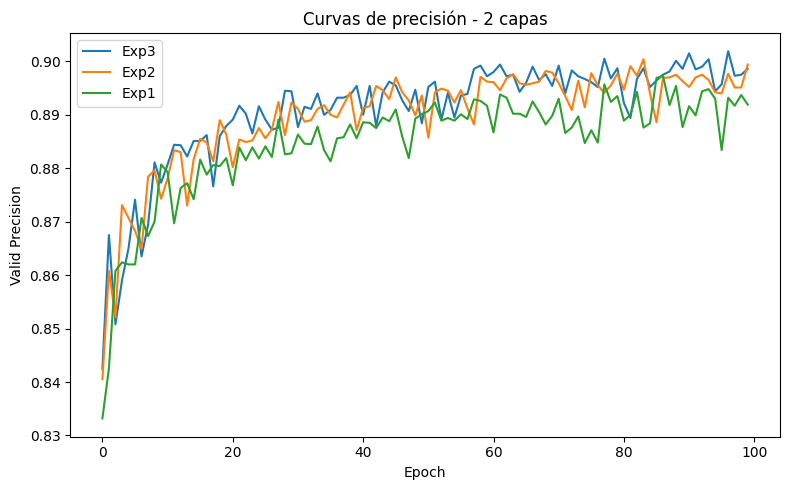

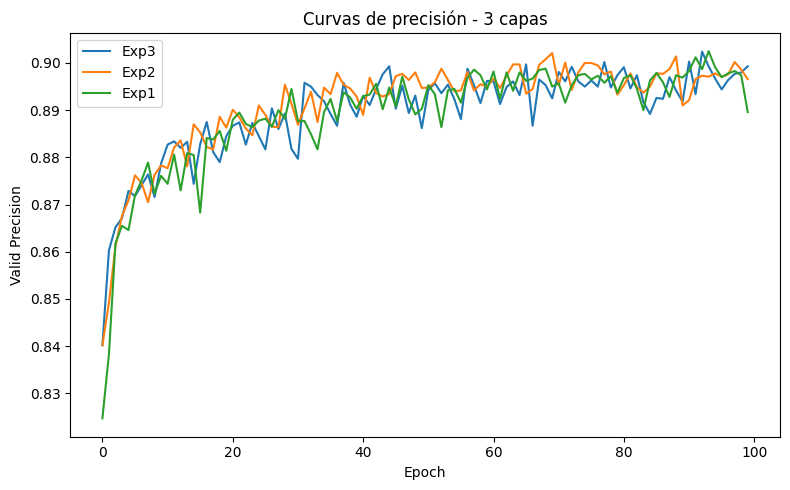

In [48]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt


# ---------------------------------------------------------
# Funciones
# ---------------------------------------------------------

def cargar_resultados(path):
    res = {}
    for f in os.listdir(path):
        if f.endswith("_results.pkl"):
            nombre = f.replace("_results.pkl", "")
            with open(os.path.join(path, f), "rb") as fp:
                res[nombre] = pickle.load(fp)
    return res


def suavidad(curva):
    """Mientras más pequeño sea sum(abs(diff)), más suave es."""
    return np.sum(np.abs(np.diff(curva)))


def evaluar_caso(datos):
    valid_prec = np.array(datos["valid_precision"])

    return {
        "promedio": valid_prec.mean(),
        "suavidad": suavidad(valid_prec),
        "max_precision": valid_prec.max(),
        "curva": valid_prec
    }


def elegir_mejores(resultados):
    evaluados = {}

    for nombre, datos in resultados.items():
        evaluados[nombre] = evaluar_caso(datos)

    # Mejor en promedio (mayor es mejor)
    mejor_promedio = max(evaluados.items(), key=lambda x: x[1]["promedio"])

    # Más suave (menor suavidad)
    mas_suave = min(evaluados.items(), key=lambda x: x[1]["suavidad"])

    # Mejor precisión absoluta
    mejor_max = max(evaluados.items(), key=lambda x: x[1]["max_precision"])

    return mejor_promedio, mas_suave, mejor_max, evaluados


def plot_curvas(evaluados, titulo):
    plt.figure(figsize=(8,5))
    for nombre, info in evaluados.items():
        plt.plot(info["curva"], label=nombre)

    plt.title(titulo)
    plt.xlabel("Epoch")
    plt.ylabel("Valid Precision")
    plt.legend()
    plt.tight_layout()
    plt.show()


# ---------------------------------------------------------
# Cargar resultados
# ---------------------------------------------------------

res_2 = cargar_resultados("results/2capas")
res_3 = cargar_resultados("results/3capas")

# ---------------------------------------------------------
# Evaluaciones
# ---------------------------------------------------------

best_prom_2, best_suave_2, best_max_2, eval_2 = elegir_mejores(res_2)
best_prom_3, best_suave_3, best_max_3, eval_3 = elegir_mejores(res_3)

print("\n=====================")
print("MEJORES 2 CAPAS")
print("=====================")
print("Mejor promedio:", best_prom_2)
print("Más suave:", best_suave_2)
print("Mejor precisión:", best_max_2)

print("\n=====================")
print("MEJORES 3 CAPAS")
print("=====================")
print("Mejor promedio:", best_prom_3)
print("Más suave:", best_suave_3)
print("Mejor precisión:", best_max_3)


# ---------------------------------------------------------
# Graficar
# ---------------------------------------------------------

plot_curvas(eval_2, "Curvas de precisión - 2 capas")
plot_curvas(eval_3, "Curvas de precisión - 3 capas")
